# Imports

In [2]:
import numpy as np
import pandas as pd
import os
import scipy

from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='whitegrid')

from os.path import join as pjoin

import itertools as it

%config InteractiveShell.ast_node_interactivity='all'
%config InlineBackend.figure_format = 'svg'

# Data

In [3]:
path= '/home/rdmtinez/Desktop/MScThesis/data_o/calibration/community_calibration/parsed_data'

#load data
df = pd.read_csv(pjoin(path, 'sc_total_spectrum.csv'), index_col=0)

In [4]:
# subtract 96th well's values from the rest as this 
# is the control well, i.e. BLANK
for col in df.columns[4:].values:
    #subtract 'blank' well values
    df.loc[:,col] = df.loc[:,col] - df.loc['H12',col]

In [5]:
df.head()
df[df['row']=='H']['560']
df[df['col']==12]['560']

,row,col,500,510,520,530,540,550,560,570,...,660,670,680,690,700,710,720,730,740,750
well,,,,,,,,,,,,,,,,,,,,,
A1,A,1,1.6336,1.4561,1.2257,1.1402,1.0946,1.0732,1.0549,1.0581,...,1.2798,1.4125,1.4652,1.2293,0.9723,0.8896,0.8541,0.8298,0.8166,0.8032
A2,A,2,1.5460,1.4074,1.1632,1.0865,1.0470,1.0245,1.0075,1.0087,...,1.2044,1.3205,1.3658,1.1698,0.9243,0.8486,0.8149,0.7924,0.7793,0.7660
A3,A,3,1.4574,1.3309,1.0982,1.0271,0.9892,0.9676,0.9512,0.9515,...,1.1188,1.2301,1.2734,1.0813,0.8680,0.7985,0.7672,0.7458,0.7334,0.7209
A4,A,4,1.3747,1.2601,1.0434,0.9784,0.9445,0.9232,0.9071,0.9059,...,1.0456,1.1440,1.1832,1.0131,0.8222,0.7584,0.7300,0.7094,0.6977,0.6858
A5,A,5,1.3221,1.2020,1.0146,0.9537,0.9187,0.9003,0.8835,0.8808,...,0.9979,1.0872,1.1227,0.9692,0.7939,0.7354,0.7079,0.6883,0.6763,0.6646


well
H1     0.6999
H2     0.6313
H3     0.5892
H4     0.5630
H5     0.5084
H6     0.4475
H7     0.3913
H8     0.3235
H9     0.2445
H10    0.1935
H11    0.1298
H12    0.0000
Name: 560, dtype: float64

well
A12    0.4780
B12    0.3868
C12    0.3888
D12    0.3008
E12    0.2673
F12    0.2041
G12    0.1378
H12    0.0000
Name: 560, dtype: float64

# Explore

In [6]:
hwells = df[df.index.str.contains('H')]
zwells = df[df.index.str.contains('12')]
rwells = hwells.append(zwells).drop(['row', 'col'], axis=1)
#lambdas = [440, 485, 520, 560, 600, 635, 680, 720, 750, 800]
lambdas = [440, 485, 560, 600, 680, 720, 750]

In [7]:
def corr_map(dframe, lambdas, method='pearson'):
    """Plots the minimum of the pairwise correlations give, and is used to find
    the best possible Regress TO wavelength. This is the one that is least correlated
    to 720 AND 680... 
    
    The difference between the correlations to 720 and 680 is then taken by hmap_diffs
    with the thinking being that the greater the difference will show
    """
    corr = dframe.corr(method=method)
    crmp = corr.style.background_gradient(cmap='coolwarm')
    cmin  = pd.DataFrame(pd.Series(corr.min(), name='min'))
    cmin['x'] = [int(i) for i in corr.index.values]
    cmin = cmin[['x','min']]
    fig,ax = plt.subplots(figsize=(8,5))
    cmin.plot(x='x', y='min', ax=ax,  style='-.')
    ax.vlines(x=lambdas, ymin=cmin['min'].min(), ymax=cmin['min'].max(), colors=['y', 'r'] )
    
    ax.set_ylabel("λ's Min Pearson-Corr Value")
    ax.set_xlabel('λ')
    ax.set_title("λ-λ Correlation Minimums")
    hmap_diffs(corr, lambdas)
    hmap_minsum(corr,lambdas)
                         

In [8]:
def hmap_diffs(hmap, lambdas):

    hdf = hmap.loc[['680','720']]
    hdf.loc['diff'] = pd.Series(hdf.loc['680'] - hdf.loc['720']).abs()
    hdf.loc['x'] = [int(i) for i in hdf.columns.values]
    hdf = hdf.transpose()
    hdf.head()
    
    fig, ax = plt.subplots(figsize=(5,3))
    hdf.plot(x='x' ,y='diff',style='-.', ax=ax)
    ax.vlines(x=lambdas, ymin=hdf['diff'].min(), ymax=hdf['diff'].max())

In [9]:
def hmap_minsum(hmap, lambdas):

    hdf = hmap.loc[['680','720']]
    hdf.loc['minsum'] = pd.Series((hdf.loc['680'] + hdf.loc['720'])).abs()
    hdf.loc['x'] = [int(i) for i in hdf.columns.values]
    hdf = hdf.transpose()
    
    fig, ax = plt.subplots(figsize=(5,3))
    hdf.plot(x='x' ,y='minsum',style='-.', ax=ax)
    ax.vlines(x=lambdas, ymin=hdf['minsum'].min(), ymax=hdf['minsum'].max())

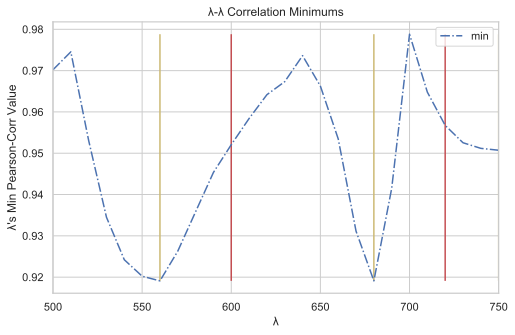

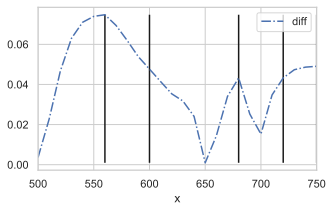

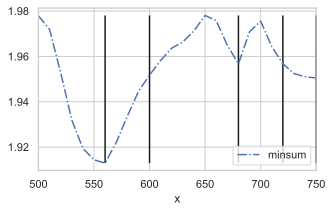

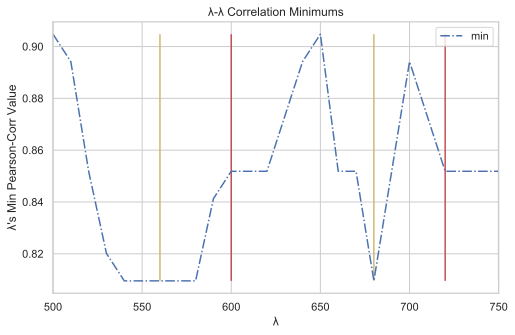

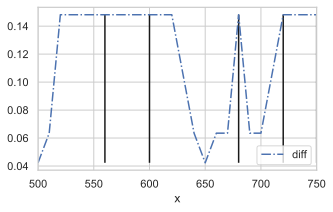

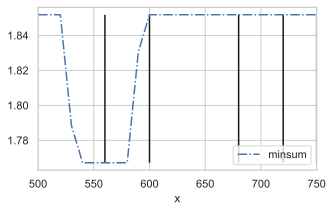

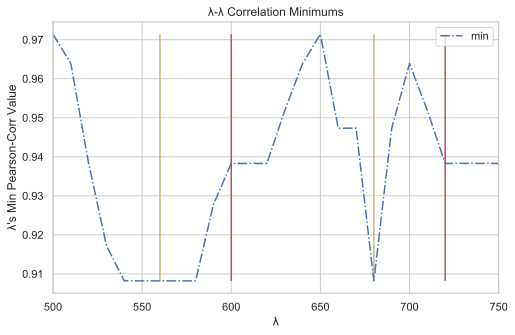

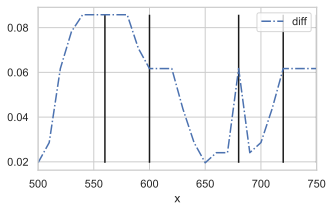

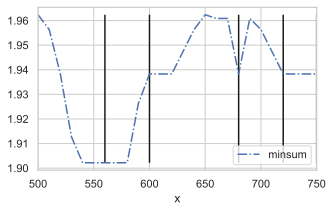

In [10]:
hmap_pearson = corr_map(rwells, lambdas)
hmap_kendall = corr_map(rwells, lambdas, method='kendall')
hmap_spearman = corr_map(rwells, lambdas, method='spearman')

In [11]:
#hmap_diffs(hmap_pearson, lambdas)
#hmap_diffs(hmap_kendall, lambdas)
#hmap_diffs(hmap_spearman, lambdas)

DataFrame.corr() is as

The modeling approach has been to apply Beer-Lambert's Law such that we determine the extinction coefficients (k) for bacteria and chlamy at two predetermined wavelengths (A680, A720) as these are the wavelengths that the PBR experiments measure and no other. We then regress back to another wavelength (and eventually back to cell counts) and use these values to get a ratio that we can compare against other empirical ratio data from the same exeperiment. In order to determine which other wavelength we should regress back to, we need to find one which is least correlated to '680' and '720'. This is done to avoid collinearity effects

To achieve this we looked at chlamy and bacteria gradients at the visible light spectrum and took their correlation values. 

that Looking at the bacteria and chalmy under the teacan microplate at the entire visible light spectrum allows us to determine which OTHER wavelength we can use as our response variable. The best wavelength other than 680 and 720 would be those which have 

basis for the model
My objective here was to try and determine which wavele

In [12]:
# look at the interesting parts of the 96 plate
# A1, A12, H1, H12
hwells = df[df.index.str.contains('H')]
zwells = df[df.index.str.contains('12')]
wells = ['A1', 'A12', 'H1', 'H12']
wells = ['A1', 'C12', 'H7', 'H12']



In [13]:
cwellst = df.loc[wells].transpose().drop(labels=['row', 'col'], axis=0)
hwellst = hwells.transpose().drop(labels=['row', 'col'], axis=0)
zwellst = zwells.transpose().drop(labels=['row', 'col'], axis=0)


In [14]:
cwellst.head()
hwellst.head()
zwellst.head()

well,A1,C12,H7,H12
500,1.6336,0.529,0.7217,0.0879
510,1.4561,0.5188,0.64,0.0876
520,1.2257,0.4219,0.4827,0
530,1.1402,0.4132,0.4389,0
540,1.0946,0.4043,0.4142,0


well,H1,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
500,1.2371,1.1179,1.0438,1.0025,0.9116,0.811,0.7217,0.6129,0.4855,0.4034,0.2978,0.0879
510,1.0803,0.9796,0.9354,0.8991,0.804,0.7174,0.64,0.5451,0.4345,0.3691,0.2714,0.0876
520,0.8614,0.7757,0.7202,0.6895,0.6253,0.5505,0.4827,0.4001,0.3039,0.24,0.1613,0
530,0.7808,0.7044,0.6558,0.6276,0.5689,0.5006,0.4389,0.3639,0.276,0.2183,0.1467,0
540,0.7377,0.6658,0.6222,0.5951,0.5373,0.4731,0.4142,0.3431,0.26,0.2064,0.138,0


well,A12,B12,C12,D12,E12,F12,G12,H12
500,0.6266,0.526,0.529,0.4319,0.3934,0.3216,0.2461,0.0879
510,0.615,0.5162,0.5188,0.4232,0.3858,0.3167,0.242,0.0876
520,0.5167,0.4194,0.4219,0.3279,0.2915,0.2225,0.1506,0
530,0.5068,0.411,0.4132,0.3207,0.2852,0.2175,0.1473,0
540,0.4966,0.4024,0.4043,0.3135,0.2787,0.2131,0.1438,0


In [15]:
slambdas = [str(i) for i in lambdas]

In [16]:
cwellst['wav'] = cwellst.index.values.astype(int)
hwellst['wav'] = hwellst.index.values.astype(int)
zwellst['wav'] = zwellst.index.values.astype(int)

In [17]:
def quickplot():

    fig, ax = plt.subplots(figsize=(9,6))
    cwellst.plot(x='wav', style='-.', ax=ax)
    lambdas = [440, 480, 490, 540, 560, 600, 680, 720, 750]    
    ax.vlines(x=lambdas, ymin=0, ymax=1.4, colors=['y', 'r'], alpha=.85)
    
    
    
    ax.set_ylabel("Absorbance")
    ax.set_xlabel('λ')
    ax.set_title("Specific Well's Absorbance Spectrum")
    
    
    ax.legend(loc='upper left')
    #ax.hlines(y=[.26, .35, .52], xmin=350, xmax=600)
    # 0 bacteria + chlamy (MAX)
    # 11 bacteria only
    # 84 chlamy only
    # 95 BLANK

    # a metabolite in the medium must be absorbing at the lower wavelengths


    # What is the sum of the values at 560:
        # b = .26
        # c = .35
        # ---------
            # .61


    # 560T = .52

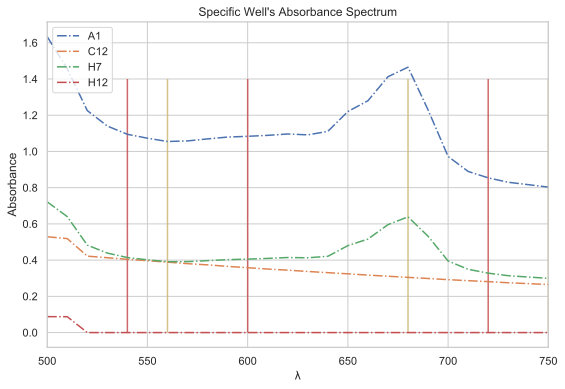

In [18]:
quickplot()


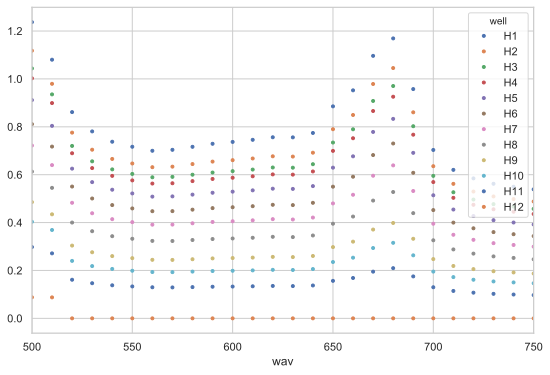

In [19]:
fig, ax = plt.subplots(figsize=(9,6))
hwellst.plot(x='wav', style='.', ax=ax)

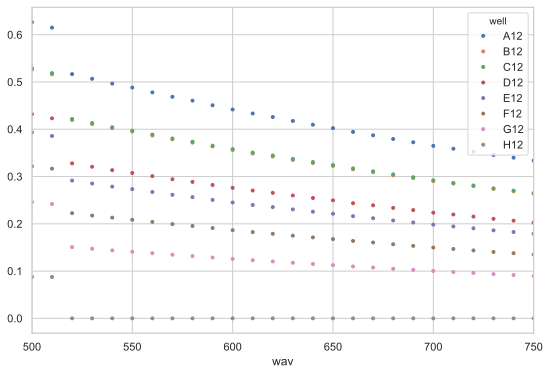

In [20]:
fig, ax = plt.subplots(figsize=(9,6))
zwellst.plot(x='wav', style='.', ax=ax)

    
    In the above graph I note that at higher-energe wavelengths the bacterial strain present at A12 tends to absorb more light; and that the absorbance gradually decreases as the wavelength increaes. Recall that the concentration of bacterium inside this well is constant, thus the decrease here is due to less light being absorbed. As the wavelength increases the contents of the bacterial cell are much smaller than the lightwave itself thus they are less readily absorbed. We do not yet know what the cell count at this well is, which is extremely unfortunate.

In [22]:
df[['500', '560', '680', '720', '730','750',]].corr().style.background_gradient(cmap='coolwarm')

,500,560,680,720,730,750
500,1,0.984208,0.992264,0.992932,0.991749,0.991222
560,0.984208,1,0.954823,0.997954,0.998493,0.998645
680,0.992264,0.954823,1,0.971172,0.968825,0.967863
720,0.992932,0.997954,0.971172,1,0.999946,0.999872
730,0.991749,0.998493,0.968825,0.999946,1,0.99998
750,0.991222,0.998645,0.967863,0.999872,0.99998,1


In [26]:
regress_to = ['440', '480', '500', '560', '635', '680', '720', '750', '800']

In [22]:
#hwells.iloc[:,5:].corr().style.background_gradient(cmap='coolwarm')
df.iloc[:,2:].corr().style.background_gradient(cmap='coolwarm')

,500,510,520,530,540,550,560,570,580,590,600,610,620,630,640,650,660,670,680,690,700,710,720,730,740,750
500,1,0.998495,0.993989,0.98881,0.985732,0.984549,0.984208,0.986338,0.988969,0.991518,0.99321,0.994738,0.996056,0.996706,0.997917,0.999778,0.999095,0.995483,0.992264,0.997455,0.998711,0.995163,0.992932,0.991749,0.991354,0.991222
510,0.998495,1,0.998026,0.994919,0.992883,0.991995,0.991763,0.993243,0.995008,0.996605,0.997582,0.998377,0.998965,0.999203,0.99947,0.998152,0.99567,0.989233,0.984535,0.992614,0.999675,0.99868,0.997503,0.9968,0.996545,0.996448
520,0.993989,0.998026,1,0.99919,0.998198,0.997754,0.997587,0.998321,0.999084,0.999588,0.99974,0.999689,0.999442,0.99919,0.998383,0.993438,0.988879,0.979215,0.972833,0.984106,0.997745,0.999658,0.999688,0.999528,0.999431,0.999372
530,0.98881,0.994919,0.99919,1,0.9998,0.999633,0.999548,0.99978,0.999864,0.999622,0.999212,0.998586,0.997767,0.99719,0.995654,0.988211,0.982233,0.970347,0.962791,0.976244,0.994402,0.998335,0.999212,0.999444,0.999466,0.999442
540,0.985732,0.992883,0.998198,0.9998,1,0.999969,0.999937,0.999935,0.999695,0.999098,0.99842,0.99752,0.996427,0.995696,0.993814,0.985161,0.978493,0.965523,0.957383,0.97187,0.99221,0.99713,0.998427,0.998858,0.998945,0.998944
550,0.984549,0.991995,0.997754,0.999633,0.999969,1,0.999989,0.999911,0.999561,0.998842,0.998072,0.997076,0.995888,0.995104,0.993106,0.98402,0.977103,0.963734,0.955374,0.970208,0.99132,0.996598,0.998051,0.998558,0.998673,0.998684
560,0.984208,0.991763,0.997587,0.999548,0.999937,0.999989,1,0.999913,0.999541,0.998797,0.998006,0.996989,0.995779,0.994985,0.992964,0.983754,0.976763,0.963267,0.954823,0.969732,0.991056,0.996445,0.997954,0.998493,0.998624,0.998645
570,0.986338,0.993243,0.998321,0.99978,0.999935,0.999911,0.999913,1,0.999852,0.999352,0.998744,0.997914,0.996888,0.9962,0.99442,0.985983,0.979424,0.966593,0.958482,0.97268,0.9926,0.997374,0.998635,0.999067,0.999171,0.999191
580,0.988969,0.995008,0.999084,0.999864,0.999695,0.999561,0.999541,0.999852,1,0.999823,0.999458,0.998876,0.998095,0.99755,0.996087,0.988698,0.982733,0.970818,0.963178,0.976445,0.99446,0.998393,0.999308,0.999586,0.999647,0.999658
590,0.991518,0.996605,0.999588,0.999622,0.999098,0.998842,0.998797,0.999352,0.999823,1,0.9999,0.99959,0.999078,0.998688,0.997571,0.991333,0.986021,0.975115,0.967997,0.980238,0.996163,0.999173,0.999708,0.999815,0.999829,0.99983


In [28]:
rwells = hwells.append(zwells)
rwells.head()

,row,col,320,325,330,335,340,345,350,355,...,755,760,765,770,775,780,785,790,795,800
well,,,,,,,,,,,,,,,,,,,,,
H1,H,1,1.0345,1.0036,0.6053,0.6110,0.6115,0.6035,0.5930,0.5844,...,0.2625,0.2602,0.2579,0.2553,0.2535,0.2516,0.2497,0.2480,0.2462,0.2448
H2,H,2,1.0014,0.9701,0.5715,0.5765,0.5766,0.5689,0.5578,0.5487,...,0.2410,0.2390,0.2367,0.2343,0.2324,0.2307,0.2289,0.2275,0.2258,0.2243
H3,H,3,0.8670,0.8353,0.4341,0.4363,0.4353,0.4288,0.4201,0.4119,...,0.1826,0.1808,0.1791,0.1774,0.1756,0.1741,0.1725,0.1710,0.1695,0.1682
H4,H,4,0.8479,0.8166,0.4148,0.4167,0.4158,0.4097,0.4013,0.3943,...,0.1746,0.1728,0.1710,0.1693,0.1676,0.1664,0.1649,0.1638,0.1625,0.1614
H5,H,5,0.7856,0.7553,0.3557,0.3586,0.3586,0.3549,0.3497,0.3454,...,0.1577,0.1565,0.1551,0.1538,0.1525,0.1516,0.1505,0.1496,0.1485,0.1476


In [29]:
hmap = rwells.iloc[:,2:].corr(method='spearman')#.style.background_gradient(cmap='coolwarm')
#rwells.iloc[:,2:].corr().min()
#hmap

In [30]:
hmap.loc[['680','720']].style.background_gradient(cmap='coolwarm')

,320,325,330,335,340,345,350,355,360,365,370,375,380,385,390,395,400,405,410,415,420,425,430,435,440,445,450,455,460,465,470,475,480,485,490,495,500,505,510,515,520,525,530,535,540,545,550,555,560,565,570,575,580,585,590,595,600,605,610,615,620,625,630,635,640,645,650,655,660,665,670,675,680,685,690,695,700,705,710,715,720,725,730,735,740,745,750,755,760,765,770,775,780,785,790,795,800
680,0.977427,0.977427,0.977427,0.978932,0.983446,0.983446,0.983446,0.983446,0.986456,0.986456,0.990971,0.990971,0.990971,0.990971,0.990971,0.990971,0.990971,0.990971,0.995485,0.995485,0.99699,0.998495,0.998495,0.998495,0.998495,0.998495,0.998495,0.998495,0.998495,0.998495,0.998495,0.998495,0.998495,0.998495,0.998495,0.99699,0.995485,0.990971,0.990971,0.977427,0.974417,0.972912,0.968397,0.942814,0.942814,0.93529,0.93529,0.93529,0.93529,0.93529,0.93529,0.93529,0.93529,0.942814,0.942814,0.942814,0.942814,0.942814,0.942814,0.948834,0.968397,0.968397,0.968397,0.968397,0.974417,0.974417,0.986456,0.990971,0.990971,0.995485,0.998495,0.998495,1,0.998495,0.995485,0.981941,0.974417,0.948834,0.93529,0.927765,0.927765,0.918736,0.918736,0.918736,0.909707,0.909707,0.909707,0.909707,0.909707,0.909707,0.909707,0.909707,0.909707,0.899172,0.899172,0.899172,0.899172
720,0.980436,0.980436,0.980436,0.978932,0.974417,0.974417,0.974417,0.974417,0.968397,0.968397,0.962378,0.962378,0.962378,0.962378,0.962378,0.962378,0.962378,0.962378,0.950339,0.950339,0.942814,0.933785,0.933785,0.933785,0.933785,0.933785,0.933785,0.933785,0.933785,0.933785,0.933785,0.933785,0.933785,0.933785,0.933785,0.942814,0.950339,0.962378,0.962378,0.977427,0.983446,0.984951,0.989466,0.99699,0.99699,0.998495,0.998495,0.998495,0.998495,0.998495,0.998495,0.998495,0.998495,0.99699,0.99699,0.99699,0.99699,0.99699,0.99699,0.995485,0.989466,0.989466,0.989466,0.989466,0.983446,0.983446,0.966892,0.962378,0.962378,0.950339,0.933785,0.933785,0.927765,0.933785,0.950339,0.971407,0.983446,0.995485,0.998495,1,1,0.998495,0.998495,0.998495,0.99699,0.99699,0.99699,0.99699,0.99699,0.99699,0.99699,0.99699,0.99699,0.995485,0.995485,0.995485,0.995485


In [31]:
hdf = hmap.loc[['680','720']]
hdf.loc['diff'] = pd.Series(hdf.loc['680'] - hdf.loc['720']).abs()
hdf.loc['x'] = [int(i) for i in hdf.columns.values]
hdf = hdf.transpose()
hdf.head()

,680,720,diff,x
320,0.977427,0.980436,0.003010,320.0
325,0.977427,0.980436,0.003010,325.0
330,0.977427,0.980436,0.003010,330.0
335,0.978932,0.978932,0.000000,335.0
340,0.983446,0.974417,0.009029,340.0


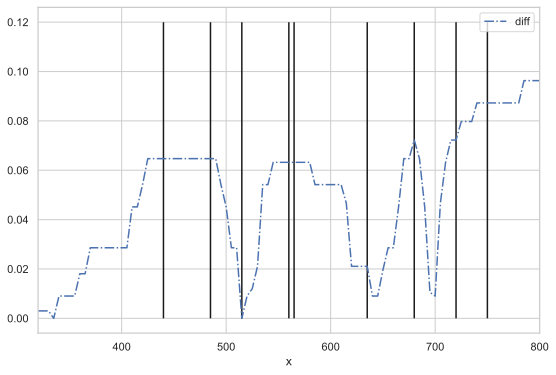

In [32]:
fig, ax = plt.subplots(figsize=(9,6))
hdf.plot(x='x' ,y='diff',style='-.', ax=ax)
ax.vlines(x=[440, 485, 515, 560, 565, 635, 680, 720, 750], ymin=0, ymax=.12)

In [ ]:
corr_min = pd.DataFrame(pd.Series(rwells.iloc[:,2:].corr().min(), name='min'))
# create an x-axis to be able to set vertical lines
corr_min['x'] = [int(i) for i in corr_min.index.values]

In [ ]:
corr_min = corr_min[['x','min']]

In [ ]:
corr_min.head()

In [ ]:
fig,ax = plt.subplots()
lambdas = [440, 485, 515, 520, 560, 600, 635, 680, 720, 750, 800]
corr_min.plot(x='x', y='min', ax=ax, figsize=(9,6))
ax.vlines(x=lambdas, ymin=0.840, ymax=1, colors=['y', 'r'] )